# To do:
* convert this into scripts
* have images in a folder
* create a readme presentation
    * what is the data
    * why did we choose the target (HIV_rel_infection) we did?
    * info on features and feature selection
    


# Forecasting-HIV-Infections Case Study

## Case Study Goal
1)	To accurately model HIV incidences (new infections per 100,000) in US 
counties by building a linear regression model that utilizes HIV infection data,
census data, data on the opioid crisis, and data on sexual orientation.

2)	Identify features that are the most significant drivers of HIV infection 
rates.

## Background
Due to the development of anti-retroviral therapies the HIV/AIDS epidemic is 
generally considered to be under control in the US.  However, as of 2015 there 
were 971,524 people living with diagnosed HIV in the US with an estimation of 
37,600 new HIV diagnoses in 2014.  HIV infection rates continue to be particularly
problematic in communities of color, among men who have sex with men (MSM), the
transgender community, and other vulnerable populations in the US. Socioeconomic 
factors are a significant risk factor for HIV infection and likely contribute 
to HIV infection risk in these communities.  The current US opioid crisis has 
further complicated the efforts to combat HIV with HIV infection outbreaks now 
hitting regions that weren’t previously thought to be vulnerable to such outbreaks.  

A model that can accurately forecast regional HIV infection rates would be 
beneficial to local public health officials.  Provided with this information, 
these officials will be able to better marshal the resources necessary to combat
HIV and prevent outbreaks from occurring.  Accurate modeling will also identify 
risk factors for communities with high HIV infection rates and provide clues 
as to how officials may better combat HIV in their respective communities.

## Data Sources

The `./data` folder contains data from three publically available sources.  Groups should feel
free to supplement this data if they wish.
1. The largest collection of HIV and opioid data was obtained from the [opioid database](http://opioid.amfar.org/) maintained by the American Foundation for AIDS Research (amfAR).  
2. Demographic and economic data were obtained from the 5yr - American Community Survey which are available at the [US census bureau website](https://factfinder.census.gov/faces/nav/jsf/pages/searchresults.xhtml?refresh=t).
3. Estimates for the [MSM population](http://emorycamp.org/item.php?i=48) in each county were obtained from the Emory Coalition for Applied Modeling for Prevention (CAMP).


In [107]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Read in the merged dataframe provided to us:
The `merge_data.ipynb` notebook reads and merges most of the data in the 
`data` folder into one dataframe.  I saved the merged DataFrame as a single file, to make it easier for EDA.

In [73]:
# I added several new features to the data from the initial data input sources, which is in the merge_data.ipynb notebook

df_main = pd.read_excel('data/combined_df.xlsx', index_col=0)
df_main.head()

,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,Med_AMAT_fac,...,ADULTMEN,MSM12MTH,MSM5YEAR,%msm12month,%msm5yr,unemployment_rate,poverty_rate,household_income,Mean income,Median income
0,1001.0,Autauga County,AL,2015.0,0.0,5.0,10.9,225.5,1.0,0.0,...,19410.0,333.0,514.0,1.715611,2.648120,8.5,12.8,20304.0,64414,52475
1,1003.0,Baldwin County,AL,2015.0,0.0,15.0,8.7,163.9,4.0,0.0,...,69724.0,925.0,1429.0,1.326659,2.049509,8.6,13.8,73058.0,67238,50183
2,1005.0,Barbour County,AL,2015.0,0.0,0.0,0.0,436.0,1.0,0.0,...,11567.0,82.0,127.0,0.708913,1.097951,14.2,24.1,9145.0,46592,35634
3,1007.0,Bibb County,AL,2015.0,0.0,0.0,0.0,191.9,0.0,0.0,...,9508.0,119.0,184.0,1.251578,1.935212,10.9,17.0,7078.0,50508,37984
4,1009.0,Blount County,AL,2015.0,0.0,5.0,10.4,95.4,1.0,0.0,...,21368.0,601.0,928.0,2.812617,4.342943,9.3,17.3,20934.0,54689,44409


### There are several columns that relate to HIV infection or are duplicate information including:
'PLHIV', 'HIVdiagnoses', 'drugdeathrate_est', 'drugdeaths'

In [74]:
# removing columns that we don't want to use for modeling
drop_list = ['PLHIV', 'HIVdiagnoses', 'drugdeathrate_est', 'drugdeaths']
df_main.drop(drop_list, axis=1, inplace= True)

In [5]:
# it looks like there are a fair number of NaN in the df
# lets see how many
df_main.isna().sum()

In [5]:
# lets drop those rows that are all NaN
# this will actually create a problem because of the added the mean and median income columns
# easy work around:
nan_rows = df_main[df_main['county_code'].isna() == True].index
df_main.drop(nan_rows, axis=0, inplace= True)

# lets fill the rest of those NaN with zeros
df_main.fillna(0, inplace= True)

Unnamed: 0           0
county_code          0
COUNTY               0
STATEABBREVIATION    0
YEAR                 0
AMAT_fac             0
HIVincidence         0
HIVprevalence        0
MH_fac               0
Med_AMAT_fac         0
Med_MH_fac           0
Med_SA_fac           0
Med_SMAT_fac         0
Med_TMAT_fac         0
Population           0
SA_fac               0
SMAT_fac             0
TMAT_fac             0
drugdeathrate        0
mme_percap           0
partD30dayrxrate     0
pctunins             0
num_SSPs             0
bup_phys             0
drugdep              0
pctunmetneed         0
nonmedpain           0
ADULTMEN             0
MSM12MTH             0
MSM5YEAR             0
%msm12month          0
%msm5yr              0
unemployment_rate    0
poverty_rate         0
household_income     0
Mean income          0
Median income        0
dtype: int64

### Engineering new features
* I will model the growth of HIV relative to previous rate of infection instead of any of the other HIV infection-related parameters
* This should allow for better understanding of what features contribute to increase HIV infection rate

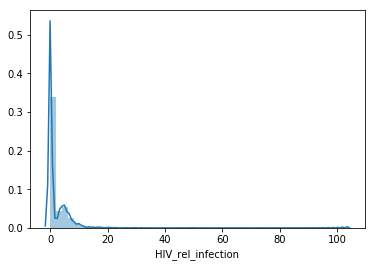

In [75]:
# to do that, need to drop rows with no HIVprevalence
df_main = df_main[df_main['HIVprevalence']> 0]
df_main['HIV_rel_infection'] = (df_main['HIVincidence']/ df_main['HIVprevalence']) * 100

# what does the distribution of this look like?
sns.distplot(df_main['HIV_rel_infection']);

In [76]:
# how many values are there?
print(df_main['HIV_rel_infection'].count())

# how many VERY high values are there?
print(df_main['HIV_rel_infection'][df_main['HIV_rel_infection']>15].count())

2424
28


In [77]:
# dropping those high df_main['HIV_rel_infection'] values
df_main = df_main[df_main['HIV_rel_infection'] <= 15]

In [6]:
# because the drug treatment facilities seem to have similar information, we want to combine them for a single count
# keeping those that accept medicaid separate
df_main['Num_drug_treatment_fac'] = (df_main['AMAT_fac'] + df_main['SA_fac'] + df_main['SMAT_fac'] + df_main['TMAT_fac'])
df_main['Num_med_drug_treatment_fac'] = (df_main['Med_AMAT_fac'] + df_main['Med_SA_fac'] + df_main['Med_SMAT_fac'] + df_main['Med_TMAT_fac'])

# now we can drop those original columns
drop_fac= ['AMAT_fac','Med_AMAT_fac','Med_SA_fac','Med_SMAT_fac','Med_TMAT_fac','SA_fac','SMAT_fac','TMAT_fac']
df_main.drop(drop_fac, axis=1, inplace= True)

# how many of the facilities accept medicaid?
accept_med = len((df_main[df_main['Num_drug_treatment_fac'] == df_main['Num_med_drug_treatment_fac']]))
print(accept_med)

# how many don't?
dont_accept_med = len((df_main[df_main['Num_drug_treatment_fac'] != df_main['Num_med_drug_treatment_fac']]))
print(dont_accept_med)

print("Percent that accept medicaid: {:.2f}%".format(100* accept_med/(accept_med + dont_accept_med)))

In [10]:
# I'm curious if the percent of men in the population varies
df_main['Percent_men'] = (df_main['ADULTMEN']/df_main['Population']) * 100

# Does the ratio of income metrics have an impact?
df_main['income_ratio'] = df_main['Median income']/df_main['Mean income']

# Does the relative amount of MSM activity within the year vs 5year window have any impact?
df_main['MSM_recent_ratio'] = (df_main['%msm12month']/df_main['%msm5yr']) * 100

In [11]:
# lets select which columns we want to use as predictors
all_cols = df_main.columns.tolist()
X_cols = [x for x in all_cols if x not in ['COUNTY','STATEABBREVIATION','YEAR','HIVincidence', 'HIVprevalence','HIV_rel_infection']]

# lets create our X and y as numpy arrays
X = df_main[X_cols]
y = df_main['HIV_rel_infection']

# now the DF looks pretty clean. Lets do a train/test split and keep them as pandas DF
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Now lets start EDA on potential features.
### First, I'll look through a few categories of features and look for colinear features to avoid

In [13]:
potential_features = X_train.columns.tolist()

drug_related_features = ['mme_percap','drugdeathrate','partD30dayrxrate','pctunins','num_SSPs','bup_phys','drugdep','pctunmetneed','nonmedpain']
income_related_features = ['unemployment_rate','poverty_rate','household_income','Mean income','Median income',]
msm_features = ['ADULTMEN','MSM12MTH','MSM5YEAR','%msm12month','%msm5yr']
facilities_features = ['MH_fac','Med_MH_fac','Num_drug_treatment_fac','Num_med_drug_treatment_fac']

In [15]:
# note, this code creates a large pairplot/scatter-matrix

# plt.figure(figsize=(12,12))
# sns.pairplot(X_train[drug_related_features], diag_kind = 'kde')
# plt.xticks(rotation= 85, fontsize= 10)
# # plt.tight_layout(pad= 3)
# plt.title('Drug Related Features', fontsize= 30)

## Drug related Features that show strong colinearity:
1. Drugdep (Percent of People 12+ Reporting Drug Dependence) and nonmedpain (Percent of Population 12 or Older Reporting Non-medical Use of Pain Relievers)
2. drugdeathrate (The rate of death from drug poisoning, including both illicit and prescription drugs, per 100,000 population.) and mme_percap (Opioids prescribed per capita, in morphine mg equivalents (MME))

### Otherwise, there are many features that may have a linear relationship, but have a lot of scatter in the data

In [16]:
# note, this code creates a large pairplot/scatter-matrix


# plt.figure(figsize=(12,12))
# sns.pairplot(X_train[income_related_features], diag_kind = 'kde')
# plt.xticks(rotation= 85, fontsize= 10)
# # plt.tight_layout(pad= 3)
# plt.title('Income Related Features', fontsize= 30)

## Income features that show strong colinearity
1. poverty_rate and unemployment_rate
2. Mean income and Median income

In [17]:
# note, this code creates a large pairplot/scatter-matrix


# plt.figure(figsize=(12,12))
# sns.pairplot(X_train[msm_features], diag_kind = 'kde')
# plt.xticks(rotation= 85, fontsize= 10)
# plt.tight_layout(pad= 3)
# plt.title('MSM Features', fontsize= 30)

# MSM features that show strong colinearity
1. ADULTMEN and MSM12MTH
2. ADULTMEN and MSM5YEAR
3. MSM12MTH and MSM5YEAR
4. %msm12month and %msm5yr

In [18]:
# note, this code creates a large pairplot/scatter-matrix

# plt.figure(figsize=(12,12))
# sns.pairplot(X_train[facilities_features], diag_kind = 'kde')
# plt.xticks(rotation= 85, fontsize= 10)
# # plt.tight_layout(pad= 3)
# plt.title('Facilities Features', fontsize= 30)

## Facilities features that show strong colinearity
1. MH_fac and Num_med_drug_treatment_fac
2. MH_fac and Num_drug_treatment_fac
3. MH_fac and Med_MH_fac


# Features to avoid using together:
1. Drugdep and nonmedpain 
2. drugdeathrate  and mme_percap
3. poverty_rate and unemployment_rate
4. Mean income and Median income
5. MH_fac and Num_med_drug_treatment_fac
6. MH_fac and Num_drug_treatment_fac
7. MH_fac and Med_MH_fac

### From examination of pairplots, I am reducing features that seem to show obvious visual colinearity

In [19]:
# the reduced list of potential features from EDA and visualization:
reduced_feature_list = ['Population','drugdeathrate','mme_percap','partD30dayrxrate','pctunins','num_SSPs','pctunmetneed',
                        '%msm12month','MSM_recent_ratio','poverty_rate','Mean income','Num_drug_treatment_fac','Percent_men','income_ratio']

In [79]:
# note, this creates a large pairplot/scatter-matrix

# plt.figure(figsize=(12,12))
# sns.pairplot(X_train[reduced_feature_list], diag_kind = 'kde')
# plt.xticks(rotation= 85, fontsize= 10)
# # plt.tight_layout(pad= 3)
# plt.title('Reduced Features', fontsize= 30)

### I will use a stepwise Backward Elimination approach to build the best model from the potential features.

In [21]:
# this function will iteratively model all the features, test removing the worst feature, and see if it improves model fit

import statsmodels.formula.api as sm
from sklearn.preprocessing import StandardScaler

def backwardElimination(X, Y, SL):
    numVars = X.shape[1]
    temp = np.zeros((X.shape)).astype(int)
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, X).fit()
        maxVar = max(regressor_OLS.pvalues)
        adjR_before = regressor_OLS.rsquared_adj.astype(float)
        if maxVar > SL:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    temp[:,j] = X[:, j]
                    X = np.delete(X, j, 1)
                    tmp_regressor = sm.OLS(Y, X).fit()
                    adjR_after = tmp_regressor.rsquared_adj.astype(float)
                    if (adjR_before >= adjR_after):
                        X_rollback = np.hstack((X, temp[:,[0,j]]))
                        X_rollback = np.delete(X_rollback, j, 1)
                        print (regressor_OLS.summary())
                        return X_rollback
                    else:
                        continue
    print(regressor_OLS.summary())
    return X

In [22]:
# lets test this with the full set of features selected from EDA
backward_elim_results = backwardElimination(X_train[reduced_feature_list].values,y_train.values, 0.05)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     111.8
Date:                Wed, 12 Jun 2019   Prob (F-statistic):          4.08e-207
Time:                        14:40:01   Log-Likelihood:                -4144.6
No. Observations:                1797   AIC:                             8313.
Df Residuals:                    1785   BIC:                             8379.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.655e-06   3.38e-07      4.899      0.0

In [23]:
# run again with same hyper-params and see if we get the same features
backward_elim_results2 = backwardElimination(X_train[reduced_feature_list].values,y_train.values, 0.05)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     111.8
Date:                Wed, 12 Jun 2019   Prob (F-statistic):          4.08e-207
Time:                        14:40:01   Log-Likelihood:                -4144.6
No. Observations:                1797   AIC:                             8313.
Df Residuals:                    1785   BIC:                             8379.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.655e-06   3.38e-07      4.899      0.0

### The first two backward elimination using OLS have REALLY bad stats. We get the same features from the repeated backward eliminations, which are:
* population
* drugdeathrate
* mme_percap
* partD30rxrate
* %msm12month (bad p-value)
* poverty_rate
* Num_drug_treatment_fac
* Percent_men (bad p-value)
* income_ratio (bad p-value)

### The target (HIV_rel_infection) has a very narrow value-range, which may be impacting the model fit.
### Lets see if applying a log-transformation on the target improves the modeling.
* in order to do that, I'll need to drop all rows with an instance of 0 for our target


In [26]:
df_pos_inf = df_main[df_main['HIV_rel_infection'] > 0]
print("after dropping zeros, there are {} rows".format(df_pos_inf.shape[0]))
print("and before there were {} rows".format(df_main.shape[0]))
print("Thats a {:.2f}% reduction!".format(100 * (df_main.shape[0]-df_pos_inf.shape[0])/df_main.shape[0]))

X2 = df_pos_inf[reduced_feature_list]
y2 = df_pos_inf['HIV_rel_infection']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)

after dropping zeros, there are 718 rows
and before there were 2396 rows
Thats a 70.03% reduction!


In [81]:
# testing the stepwise backward elimination
backward_elim_results3 = backwardElimination(X2_train[reduced_feature_list].values,np.log(y2_train.values), 0.05)
results3_df = pd.DataFrame(backward_elim_results3)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     817.2
Date:                Wed, 12 Jun 2019   Prob (F-statistic):          8.89e-323
Time:                        15:04:33   Log-Likelihood:                -259.80
No. Observations:                 538   AIC:                             541.6
Df Residuals:                     527   BIC:                             588.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          7.286e-08   5.68e-08      1.284      0.2

### WOW that model looks better! Lets figure out which features are important.

backward_elim_results3 was training with the reduced_features_list from EDA and selected the following features:
* population  (bad p-value)
* drugdeathrate
* pctunins (bad p-value)
* num_SSPs
* %msm12month 
* MSM_recent_ratio (bad p-value)
* Mean income  
* Num_drug_treatment_fac 
* Percent_men  
* constant (bad p-value)
* mme_percap


In [84]:
# if we give it all possible features, what will we get back?
X3 = df_pos_inf[potential_features]
y3 = df_pos_inf['HIV_rel_infection']
X3_train, X3_test, y3_train, y3_test = train_test_split(X2, y2)


backward_elim_results4 = backwardElimination(X3_train.values,np.log(y3_train.values), 0.05)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     697.2
Date:                Wed, 12 Jun 2019   Prob (F-statistic):          3.76e-321
Time:                        15:09:13   Log-Likelihood:                -253.39
No. Observations:                 538   AIC:                             532.8
Df Residuals:                     525   BIC:                             588.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          9.333e-08   5.73e-08      1.628      0.1

In [31]:
results4_df = pd.DataFrame(backward_elim_results4)
# results4_df.head(1)

Backward_elim_results 4 used the following columns: Backward elimination starting with all features
* Population (bad p-value)
* drugdeathrate
* mme_percap (bad p-value)
* partD30dayrxrate
* pctunins
* num_SSPs
* MSM_recent_ratio (bad p-value)
* Mean income
* Num_drg_treatment_fac
* Percent_men
* pctunmetneed (bad p-value)


backward_elim_results3 used the following features: Backward elimination starting with reduced features from EDA
* Population  (bad p-value)
* drugdeathrate
* pctunins (bad p-value)
* num_SSPs
* %msm12month 
* MSM_recent_ratio (bad p-value)
* Mean income  
* Num_drug_treatment_fac 
* Percent_men  
* constant (bad p-value)
* mme_percap


From initial model without log(y)
* Population
* drugdeathrate
* mme_percap
* partD30rxrate
* %msm12month (bad p-value)
* poverty_rate
* Num_drug_treatment_fac
* Percent_men (bad p-value)
* income_ratio (bad p-value)

### Each of the different approaches gave slightly different features, but with many features shared across each model.

### Are all of these features needed?

In [91]:
EDA_selected_features =  ['Population', 'drugdeathrate', 'mme_percap', 'partD30dayrxrate', 'num_SSPs', 'pctunmetneed', '%msm12month', 
                          'MSM_recent_ratio', 'poverty_rate', 'Mean income', 'Num_drug_treatment_fac', 'Percent_men']
step_selected_features = ['Population', 'drugdeathrate', 'mme_percap', 'partD30dayrxrate', 'pctunins','num_SSPs', 'MSM_recent_ratio',
                          'Mean income', 'Num_drug_treatment_fac', 'Percent_men', 'pctunmetneed']

# iteratively prune features until all EDA_selected_features are below 0.05
EDA_selected_pruned = ['drugdeathrate', 'partD30dayrxrate', 'num_SSPs', 'pctunmetneed', '%msm12month', 'Mean income']

# iteratively prune features until all step_selected_features are below 0.05
step_selected_pruned = ['drugdeathrate', 'partD30dayrxrate', 'num_SSPs','pctunins', 'MSM_recent_ratio', 'Mean income']

# these two lists converge on essentially the same features, with adjusted_R_squared of each at 0.94

In [86]:
# Fitting the Linear regression model with just the features from backward_elim_results3 with good p-values
smaller_model_EDA = sm.OLS(np.log(y2_train.values), X2_train[EDA_selected_features].values).fit()
smaller_model_EDA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     742.1
Date:                Wed, 12 Jun 2019   Prob (F-statistic):          1.68e-320
Time:                        15:12:04   Log-Likelihood:                -261.69
No. Observations:                 538   AIC:                             547.4
Df Residuals:                     526   BIC:                             598.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.108e-07   5.63e-08      1.969      0.049    2.78e-10    2.21e-07
x2            -0.0074      0.002     -4.589      0.000      -0.011      -0.004
x3         -5.564e-05   5.83e-05     -0.955      0.340      -0.000    5.88e-05
x4             0.0595      0.020      2.926      0.004       0.020       0.099
x5            -0.0537      0.029     -1.868      0.062      -0.110       0.003
x6             0.0058      0.005      1.050      0.294      -0.005       0.017
x7            -0.0300      0.017     -1.760      0.079      -0.064       0.003
x8             0.0291      0.008      3.468      0.001       0.013       0.046
x9             0.0066      0.003      2.086      0.037       0.000       0.013
x10        -2.219e-06   1.08e-06     -2.054      0.040   -4.34e-06    -9.7e-08
x11           -0.0023      0.001     -2.152      0.032      -0.004      -0.000
x12           -0.0188      0.006     -2.997      0.003      -0.031      -0.006
==============================================================================
Omnibus:                        0.778   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.678   Jarque-Bera (JB):                0.716
Skew:                          -0.089   Prob(JB):                        0.699
Kurtosis:                       3.015   Cond. No.                     1.29e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [89]:
# EDA features pruned
smaller_model_EDA_pruned = sm.OLS(np.log(y2_train.values), X2_train[EDA_selected_pruned].values).fit()
smaller_model_EDA_pruned.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1436.
Date:                Wed, 12 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:12:48   Log-Likelihood:                -272.96
No. Observations:                 538   AIC:                             557.9
Df Residuals:                     532   BIC:                             583.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0078      0.001     -5.232      0.000      -0.011      -0.005
x2             0.0705      0.018      3.894      0.000       0.035       0.106
x3            -0.0702      0.025     -2.819      0.005      -0.119      -0.021
x4             0.0203      0.001     21.181      0.000       0.018       0.022
x5            -0.0328      0.016     -2.009      0.045      -0.065      -0.001
x6         -2.777e-06   1.06e-06     -2.610      0.009   -4.87e-06   -6.87e-07
==============================================================================
Omnibus:                        4.082   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.130   Jarque-Bera (JB):                3.887
Skew:                          -0.200   Prob(JB):                        0.143
Kurtosis:                       3.117   Cond. No.                     9.61e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### These EDA-derived features provide a good Adjusted R-squared statistic, show acceptable p-values, but have a very high conditional number that indicates multicolinearity

In [35]:
# Fitting the Linear regression model with just the features from backward_elim_results3 (stepwise backward selected features) with good p-values
smaller_model_step = sm.OLS(np.log(y2_train.values), X2_train[step_selected_features].values).fit()
smaller_model_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     811.9
Date:                Wed, 12 Jun 2019   Prob (F-statistic):          4.55e-322
Time:                        14:40:02   Log-Likelihood:                -261.45
No. Observations:                 538   AIC:                             544.9
Df Residuals:                     527   BIC:                             592.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          7.231e-08    5.7e-08      1.270      0.205   -3.96e-08    1.84e-07
x2            -0.0075      0.002     -4.678      0.000      -0.011      -0.004
x3         -5.033e-05    5.8e-05     -0.868      0.386      -0.000    6.36e-05
x4             0.0715      0.020      3.626      0.000       0.033       0.110
x5             0.0127      0.004      3.092      0.002       0.005       0.021
x6            -0.0593      0.028     -2.138      0.033      -0.114      -0.005
x7             0.0290      0.008      3.486      0.001       0.013       0.045
x8         -2.297e-06   1.07e-06     -2.151      0.032   -4.39e-06   -1.99e-07
x9            -0.0019      0.001     -1.793      0.074      -0.004       0.000
x10           -0.0143      0.006     -2.356      0.019      -0.026      -0.002
x11            0.0026      0.006      0.468      0.640      -0.008       0.014
==============================================================================
Omnibus:                        0.374   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.829   Jarque-Bera (JB):                0.313
Skew:                          -0.058   Prob(JB):                        0.855
Kurtosis:                       3.020   Cond. No.                     1.23e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [92]:
# step-selected features pruned
smaller_model_step_pruned = sm.OLS(np.log(y2_train.values), X2_train[step_selected_pruned].values).fit()
smaller_model_step_pruned.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     1468.
Date:                Wed, 12 Jun 2019   Prob (F-statistic):               0.00
Time:                        15:14:34   Log-Likelihood:                -267.29
No. Observations:                 538   AIC:                             546.6
Df Residuals:                     532   BIC:                             572.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0083      0.002     -5.405      0.000      -0.011      -0.005
x2             0.0701      0.018      3.966      0.000       0.035       0.105
x3            -0.0765      0.022     -3.426      0.001      -0.120      -0.033
x4             0.0148      0.004      3.816      0.000       0.007       0.022
x5             0.0238      0.002     15.248      0.000       0.021       0.027
x6         -2.567e-06   1.07e-06     -2.403      0.017   -4.67e-06   -4.69e-07
==============================================================================
Omnibus:                        3.349   Durbin-Watson:                   1.836
Prob(Omnibus):                  0.187   Jarque-Bera (JB):                3.137
Skew:                          -0.161   Prob(JB):                        0.208
Kurtosis:                       3.191   Cond. No.                     8.30e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.3e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### The stepwise backward elimination selected features also yield a model with a high adjusted R-squared value, small p-values for features, but with a high condition number as well.

In [328]:
# We will be plotting lots of residuals, so lets make a function to simplify that process.

def plot_linear_residuals(model_name, model_features, training_data):
    import statsmodels.api as sm
    model_resids = model_name.outlier_test()[:,0]
    
    ax = sm.qqplot(model_resids, line= '45')
    plt.title('QQ-plot')
    
    i  = int((len(model_features)/2))
    j = int((len(model_features) - i + 1)/2)
    if len(model_features) % 2 != 0:
        i += 1
    
    fig, axs = plt.subplots(i, j, figsize= (4*i, 4*j))
    plt.tight_layout(pad=4)
    
    for idx, val in enumerate(model_features):
        plt.subplot(i,j, idx+1, label= val)
        plt.title(f'{val} Studentized Residual Plot')
        plt.scatter(training_data[val], model_resids)
        plt.hlines(0,
                      training_data[val].min(), 
                      training_data[val].max(), 
                      'k', linestyle='dashed')
        plt.xlabel(val)
        plt.ylabel('studentized residuals');

    plt.subplot(i,j, len(model_features))
    plt.scatter(model_name.fittedvalues, model_resids)
    plt.hlines(0,
                  model_name.fittedvalues.min(), 
                  model_name.fittedvalues.max(),
                  'k', linestyle='dashed')
    plt.xlabel('predicted rel HIV infection rate')
    plt.ylabel('studentized residuals');


### Plotting residuals should give a sense for how well the model performs on training data

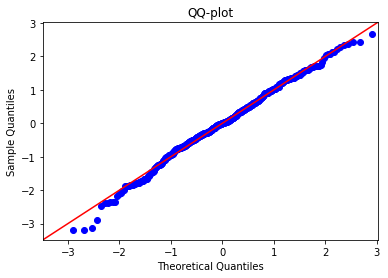

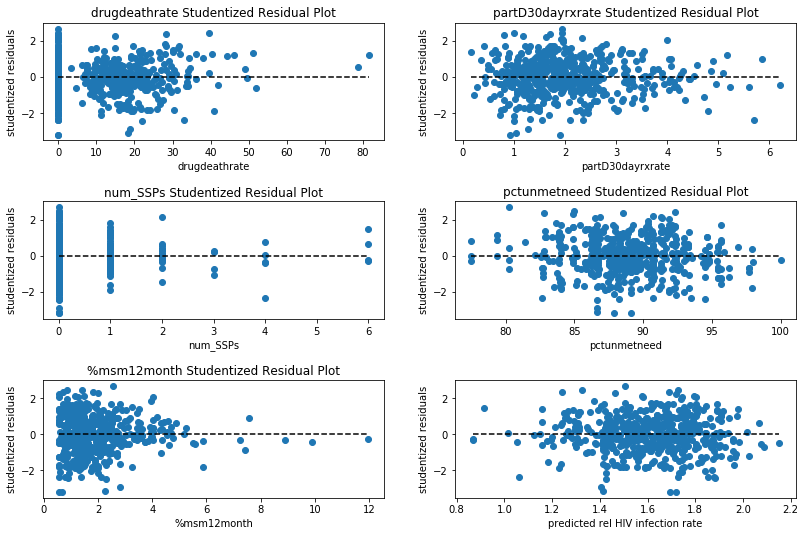

In [327]:
# First for the EDA-selected pruned features
# qqplot and Studentized residuals for EDA_selected_pruned model
plot_linear_residuals(smaller_model_EDA_pruned, EDA_selected_pruned, X2_train)

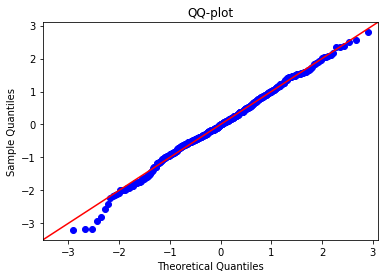

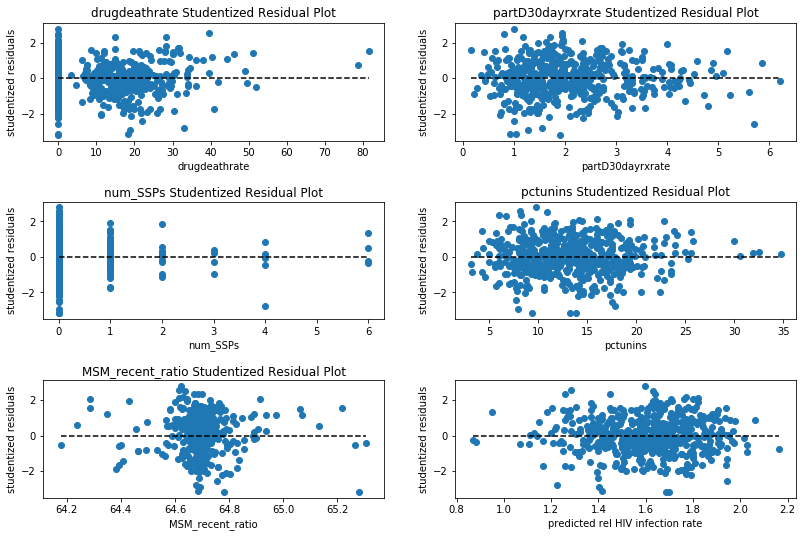

In [323]:
# Next, lets look at the stepwise backward elimination selected features
# qqplot and studentized residuals for step_selected_pruned model
plot_linear_residuals(smaller_model_step_pruned, step_selected_pruned, X2_train)

### The QQ-plots indicate a good fit using a linear regression. The residual plots show mostly homoscadastic distribution of error, but some features (especially in the EDA selected features) appear to display heteroscadastic error

### How well do these models perform on hold-out test data?

In [111]:
# what is the scale of our target value (HIV_rel_infection)?
print("Test mean: ", round(y2_test.mean(),2))

# how well does the EDA_selected_pruned model perform?
y_pred_EDA = smaller_model_EDA_pruned.predict(X2_test[EDA_selected_pruned].values)
EDA_RMSE = mean_squared_error(y2_test, np.exp(y_pred_EDA))
print("EDA-selected pruned features model RMSE: ", round(EDA_RMSE, 2))

# how well does the step_selected_pruned model perform?
y_pred_step = smaller_model_step_pruned.predict(X2_test[step_selected_pruned].values)
step_RMSE = mean_squared_error(y2_test, np.exp(y_pred_step))
print("Stepwise-selected pruned features model RMSE: ", round(step_RMSE, 2))


Test mean:  5.45
EDA-selected pruned features model RMSE:  4.24
Stepwise-selected pruned features model RMSE:  4.34


### those are large RMSE values relative to the test mean. 

### Lets visualize those predictions:

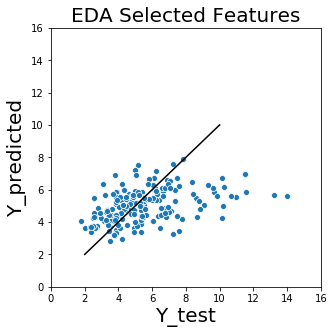

In [116]:
plt.figure(figsize=(5,5))
sns.scatterplot(y2_test.values, np.exp(y_pred_EDA))
sns.lineplot((2,10), (2, 10), color = 'k')
plt.title('EDA Selected Features', fontsize= 20)
plt.xlabel('Y_test', fontsize= 20)
plt.ylabel('Y_predicted', fontsize= 20)
plt.ylim(0, 16)
plt.xlim(0, 16)


plt.tight_layout(pad= 2)
plt.savefig('Y_test vs y_pred_EDA.png', dpi= 300)
plt.show()

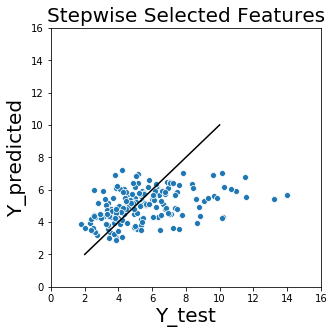

In [117]:
plt.figure(figsize=(5,5))
sns.scatterplot(y2_test.values, np.exp(y_pred_step))
sns.lineplot((2,10), (2, 10), color = 'k')
plt.title('Stepwise Selected Features', fontsize= 20)
plt.xlabel('Y_test', fontsize= 20)
plt.ylabel('Y_predicted', fontsize= 20)
plt.ylim(0, 16)
plt.xlim(0, 16)


plt.tight_layout(pad= 2)
plt.savefig('Y_test vs y_pred_step.png', dpi= 300)
plt.show()

### There are some very high y_test values, appear to skew things. Our model isn't capturing them well.

In [178]:
# lets see how our model predictions look for each feature selected.
# this function will make it simpler to visualize

def plot_linear_regression_features(y_pred, y_true, x_test, selected_features):
    # Visualising the Linear Regression results
    i  = int((len(selected_features)/2))
    j = int((len(selected_features) - i + 1)/2)
    fig, ax = plt.subplots(i, j, figsize= (4*i, 3*j))
    plt.ylabel('Relative HIV Infection Growth', fontsize= 20)
    plt.title('Target vs feature' , fontsize = 25)
#     plt.legend(fontsize= 15)  
    for idx, col in enumerate(selected_features):

        data1 = sorted(list(zip(x_test[col].values, y_true.values)))
        data2 = sorted(list(zip(x_test[col].values, np.exp(y_pred))))
        scat = list(zip(*data1))
        plot = list(zip(*data2))
        
        plt.subplot(i, j, idx + 1)
        sns.scatterplot(scat[0], scat[1], color = 'red', label= 'Y-test')
        sns.scatterplot(plot[0], plot[1], color = 'blue', label= "Y-predicted")
        plt.xlabel(f'{col}', fontsize= 15)

  
    plt.tight_layout(pad= 1)
    plt.show()

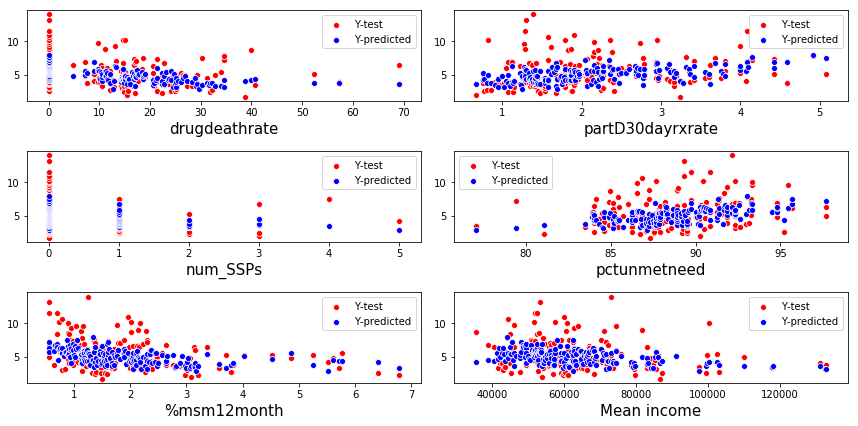

In [179]:
# Plotting y_pred and y_true values for features in EDA_selected_pruned model
plot_linear_regression_features(y_pred_EDA, y2_test, X2_test, EDA_selected_pruned)

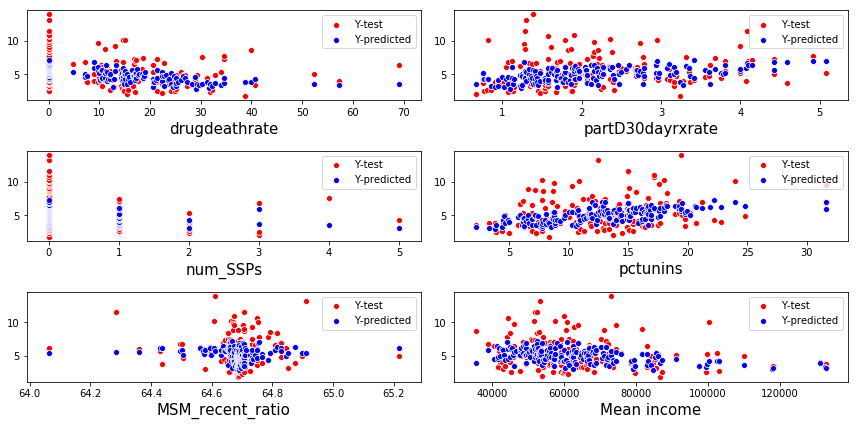

In [180]:
# Plotting y_pred and y_true values for features in step_selected_pruned model
plot_linear_regression_features(y_pred_step, y2_test, X2_test, step_selected_pruned)

### The models seem to predict the better toward the mean, and don't perform as well with more extreme values. Next, I will normalize the whole dataset and try the stepward elimination function to see if that yields better models

In [182]:
# there are many ways to normalize the data, but to run through things quickly it is easiest to just create a dataframe with normalized data
# this function will do that

def normalize_df(df):
    from sklearn import preprocessing
    norm_df = df.copy()
    col_list = df.columns.tolist().copy()
    for col in col_list:
        norm_df[f"Norm_{col}"] = preprocessing.MinMaxScaler().fit_transform(df[col].values.reshape(-1,1))
        norm_df.drop(col, axis=1, inplace= True)
    return norm_df


In [184]:
# apply normalize on data
# not that we are applying the log-transformationt to the data BEFORE normalization in order to avoid 0 values
y2 = pd.DataFrame(y2)
y2 = y2[y2['HIV_rel_infection']>0]
X2_norm = normalize_df(X2)
y2_norm = normalize_df(np.log(y2))

# split the normalized X2 df
X2_norm_train, X2_norm_test, y2_norm_train, y2_norm_test = train_test_split(X2_norm, y2_norm)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [185]:
# run the backward stepwise feature elimination with all features to check performance
norm_step_test = backwardElimination(X2_norm_train.values,y2_norm_train.values, 0.05)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     674.8
Date:                Wed, 12 Jun 2019   Prob (F-statistic):          2.65e-293
Time:                        16:00:07   Log-Likelihood:                 218.52
No. Observations:                 538   AIC:                            -417.0
Df Residuals:                     528   BIC:                            -374.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3769      0.241      1.567      0.1

In [49]:
## Stepward elimination on normalized dataframe: (the features may change upon each iteration)

norm_step_features = ['Norm_partD30dayrxrate','Norm_pctunins', 'Norm_num_SSPs', 'Norm_pctunmetneed', 
                      'Norm_%msm12month', 'Norm_MSM_recent_ratio', 'Norm_Num_drug_treatment_fac', 'Norm_income_ratio']
norm_step_pruned = ['Norm_partD30dayrxrate','Norm_pctunins', 'Norm_pctunmetneed', 
                      'Norm_%msm12month', 'Norm_MSM_recent_ratio', 'Norm_Num_drug_treatment_fac', 'Norm_income_ratio']

# reminder that the EDA_selected_features
EDA_selected_features =['Population','drugdeathrate','mme_percap','partD30dayrxrate','num_SSPs','pctunmetneed','%msm12month',
                    'MSM_recent_ratio','poverty_rate','Mean income','Num_drug_treatment_fac','Percent_men']
norm_EDA_selected_features = ["Norm_" + x for x in EDA_selected_features]
norm_EDA_pruned = ['Norm_Population','Norm_drugdeathrate','Norm_partD30dayrxrate','Norm_num_SSPs','Norm_pctunmetneed',
             'Norm_MSM_recent_ratio','Norm_poverty_rate','Norm_Num_drug_treatment_fac']

In [50]:
# Prune the backward step selected ones to below 0.05
norm_step_test = backwardElimination(X2_norm_train[norm_step_pruned].values,y2_norm_train.values, 0.05)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     1045.
Date:                Wed, 12 Jun 2019   Prob (F-statistic):          8.00e-306
Time:                        14:40:10   Log-Likelihood:                 239.46
No. Observations:                 538   AIC:                            -464.9
Df Residuals:                     531   BIC:                            -434.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1559      0.040      3.888      0.0

In [51]:
# Prune the EDA selected features on normalized data to around 0.05
norm_EDA_test = backwardElimination(X2_norm_train[norm_EDA_pruned].values,y2_norm_train.values, 0.05)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     874.2
Date:                Wed, 12 Jun 2019   Prob (F-statistic):          1.21e-299
Time:                        14:40:10   Log-Likelihood:                 228.57
No. Observations:                 538   AIC:                            -441.1
Df Residuals:                     530   BIC:                            -406.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5655      0.219      2.577      0.0

### This looks very promising. High adjusted_R_sqared values, low p-value for features, and much lower condition numbers.

In [189]:
# how well do the normalized models perform?

# Raw-data models
print("Raw test mean: ", round(y2_test.mean(), 2))
# EDA_selected_pruned model
y_pred_EDA = smaller_model_EDA_pruned.predict(X2_test[EDA_selected_pruned].values)
EDA_RMSE = mean_squared_error(y2_test, np.exp(y_pred_EDA))
print("EDA-selected pruned features model RMSE: ", round(EDA_RMSE, 2))

# step_selected_pruned model
y_pred_step = smaller_model_step_pruned.predict(X2_test[step_selected_pruned].values)
step_RMSE = mean_squared_error(y2_test, np.exp(y_pred_step))
print("Stepwise-selected pruned features model RMSE: ", round(step_RMSE, 2))

Raw test mean:  5.45
EDA-selected pruned features model RMSE:  4.24
Stepwise-selected pruned features model RMSE:  4.34


In [193]:
print("Normalized test mean: ", round(y2_norm.values.mean(), 2))
# EDA normalized model
norm_EDA_model = sm.OLS(y2_norm_train.values, X2_norm_train[norm_EDA_pruned].values).fit()
y_pred_nEDA = norm_EDA_model.predict(X2_norm_test[norm_EDA_pruned].values)
nEDA_RMSE = mean_squared_error(y2_norm_test.values, y_pred_nEDA)
print("Normalized EDA-selected pruned features model RMSE: ", round(nEDA_RMSE, 3))

# step normalized model
norm_step_model = sm.OLS(y2_norm_train.values, X2_norm_train[norm_step_pruned].values).fit()
y_pred_nstep = norm_step_model.predict(X2_norm_test[norm_step_pruned].values)
nstep_RMSE = mean_squared_error(y2_norm_test.values, y_pred_nstep)
print("Normalized step-selected pruned features model RMSE: ", round(nstep_RMSE, 3))

Normalized test mean:  0.57
Normalized EDA-selected pruned features model RMSE:  0.022
Normalized step-selected pruned features model RMSE:  0.024


### The RMSE for the normalized models look much better. Both the stepwise backward elimination and EDA selected features yield an RMSE value of approx 5% of test mean.

In [195]:
norm_step_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     945.0
Date:                Wed, 12 Jun 2019   Prob (F-statistic):          5.24e-295
Time:                        16:06:35   Log-Likelihood:                 212.14
No. Observations:                 538   AIC:                            -410.3
Df Residuals:                     531   BIC:                            -380.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1355      0.044      3.096      0.002       0.050       0.222
x2             0.2882      0.050      5.721      0.000       0.189       0.387
x3             0.1691      0.049      3.458      0.001       0.073       0.265
x4            -0.1812      0.075     -2.402      0.017      -0.329      -0.033
x5             0.3292      0.069      4.747      0.000       0.193       0.465
x6            -0.2599      0.106     -2.460      0.014      -0.467      -0.052
x7             0.3300      0.049      6.715      0.000       0.233       0.427
==============================================================================
Omnibus:                        2.012   Durbin-Watson:                   1.901
Prob(Omnibus):                  0.366   Jarque-Bera (JB):                1.999
Skew:                          -0.017   Prob(JB):                        0.368
Kurtosis:                       3.297   Cond. No.                         17.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Lets took into relative feature importance for the two models

In [240]:
# create list of tuples of feature name and relative importance
step_weights = norm_step_model.params.tolist()
sum_step_weight = sum(step_weights)
total_step_weight = sum([abs(x) for x in step_weights])
step_rel_weights = [int(100*x/total_step_weight) for x in step_weights]
step_feature_importance = list(zip(norm_step_pruned, step_rel_weights))

EDA_weights = norm_EDA_model.params.tolist()
sum_EDA_weight = sum(EDA_weights)
total_EDA_weight = sum([abs(x) for x in EDA_weights])
EDA_rel_weights = [int(100*x/total_EDA_weight) for x in EDA_weights]
EDA_feature_importance = list(zip(norm_EDA_pruned, EDA_rel_weights))

step_results_df = pd.DataFrame(step_feature_importance, columns = ['Feature', 'Impact (%)'])
EDA_results_df = pd.DataFrame(EDA_feature_importance, columns = ['Feature', 'Impact (%)'])
step_results_df["Model"] = "Stepwise"
EDA_results_df['Model'] = "EDA"
model_results_df = pd.concat([step_results_df, EDA_results_df]).sort_values(by=['Model','Impact (%)','Feature'], ascending= [False, False, True])

model_results_df

,Feature,Impact (%),Model
4,Norm_MSM_recent_ratio,19,Stepwise
6,Norm_income_ratio,19,Stepwise
1,Norm_pctunins,17,Stepwise
2,Norm_pctunmetneed,9,Stepwise
0,Norm_partD30dayrxrate,8,Stepwise
3,Norm_%msm12month,-10,Stepwise
5,Norm_Num_drug_treatment_fac,-15,Stepwise
5,Norm_MSM_recent_ratio,24,EDA
0,Norm_Population,23,EDA
4,Norm_pctunmetneed,8,EDA


### The backward stepwise elimination approach gives the best model based on adjusted_R_squared value, condition number, and model complexity

In [270]:
# lets see how our model predictions look for each feature selected.
# this function will make it simpler to visualize

def plot_linear_regression_features2(y_pred, y_true, x_test, selected_features):
    # Visualising the Linear Regression results
    i  = int((len(selected_features)/2))
    j = int((len(selected_features) - i + 1)/2)
    if len(selected_features) % 2 != 0:
        i += 1
    fig, ax = plt.subplots(i, j, figsize= (4*i, 4*j))

    for idx, col in enumerate(selected_features):

        data1 = sorted(list(zip(x_test[col].values, y_true.values)))
        data2 = sorted(list(zip(x_test[col].values, y_pred)))
        scat = list(zip(*data1))
        plot = list(zip(*data2))
        
        plt.subplot(i, j, idx + 1)
        sns.scatterplot(scat[0], scat[1], color = 'red', label= 'Y-test')
        sns.scatterplot(plot[0], plot[1], color = 'blue', label= "Y-predicted")
        plt.xlabel(f'{col}', fontsize= 15)

  
    plt.tight_layout(pad= 0.5)
    plt.show()

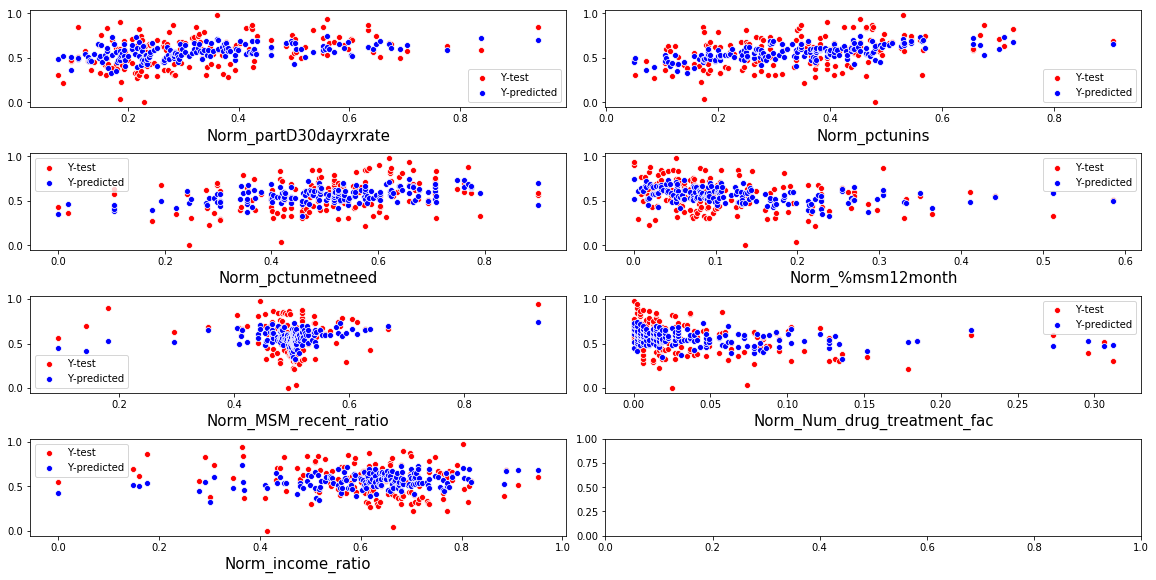

In [271]:
# Plotting y_pred and y_true values for features in Normalized step_pruned model
plot_linear_regression_features2(y_pred_nstep, y2_norm_test, X2_norm_test, norm_step_pruned)

### Visualizing residuals can be very helpful to look for data heteroscadastity and gauge the presence of outliers.
* the X-axis of the plot shows how the data is distributed
* the y-axis shows how the error distribution in the data is distributed.
* error should be uniform across the X-axis
* studentized residuals are considered outliers if > |3|

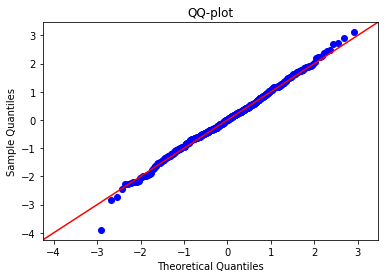

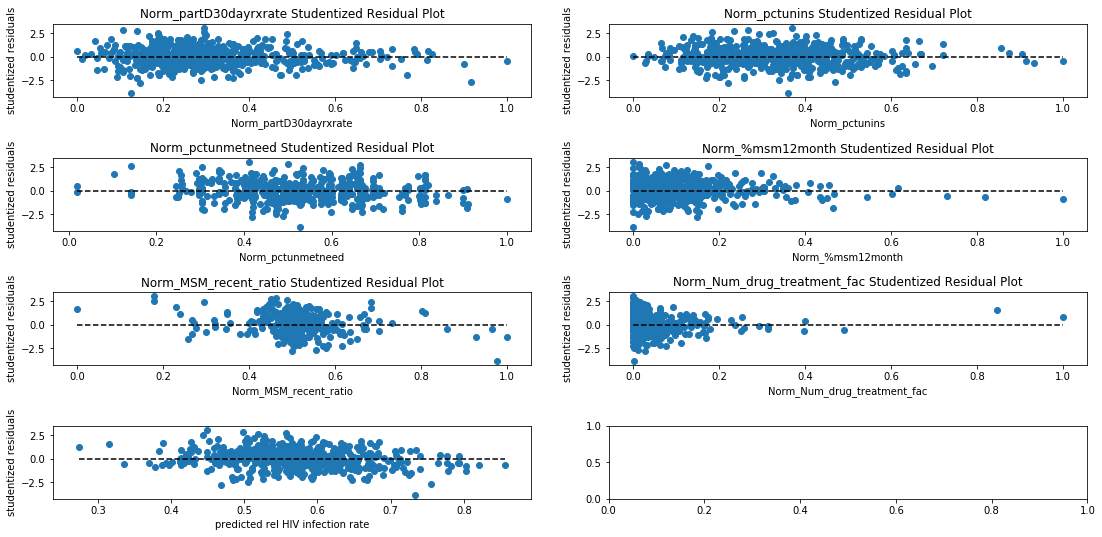

In [329]:
# qqplot and studentized residuals for Normalized step_pruned_model
plot_linear_residuals(norm_step_model, norm_step_pruned, X2_norm_train)

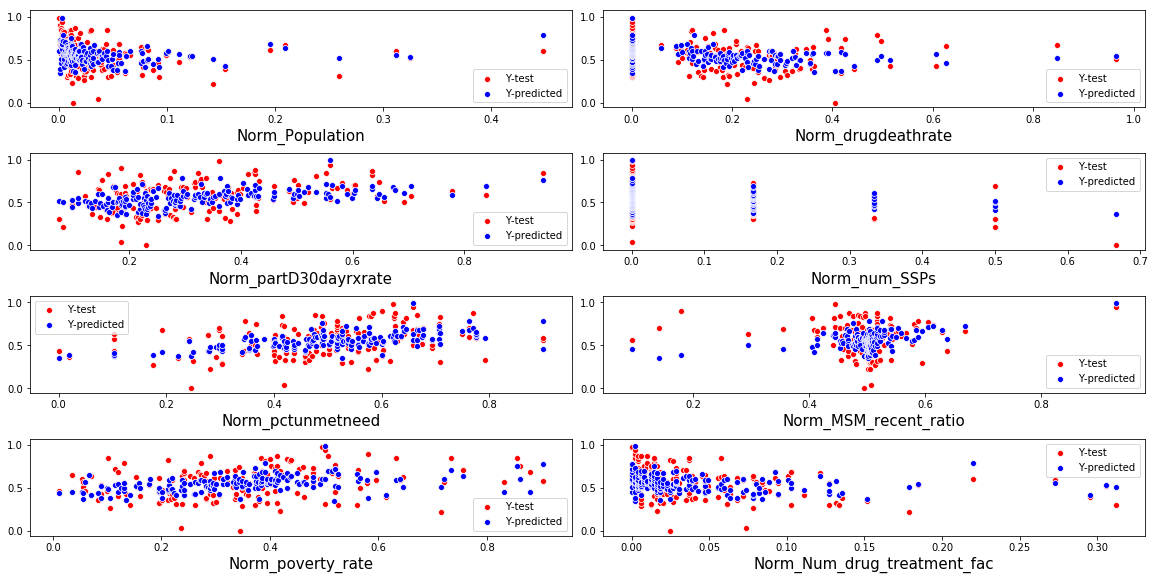

In [272]:
# Plotting y_pred and y_true values for features in Normalized EDA_pruned model
plot_linear_regression_features2(y_pred_nEDA, y2_norm_test, X2_norm_test, norm_EDA_pruned)

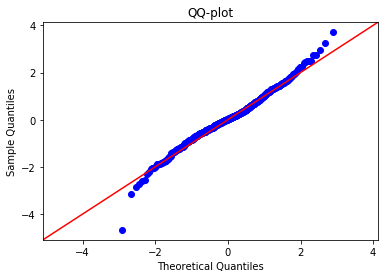

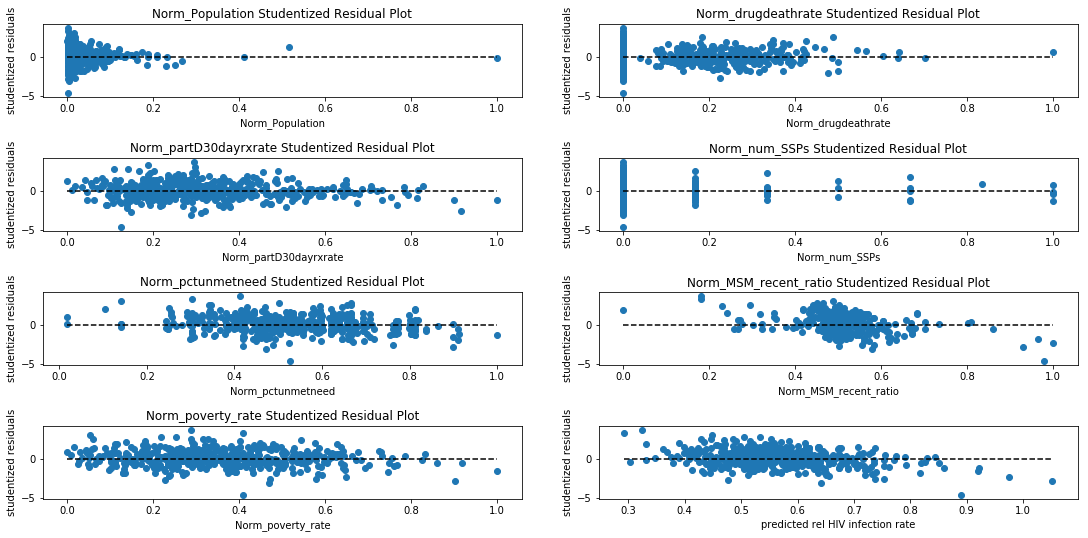

In [330]:
# qqplot and studentized residuals for Normalized EDA_pruned_model
plot_linear_residuals(norm_EDA_model, norm_EDA_pruned, X2_norm_train)

### How do the predictions and test values compare with each model?

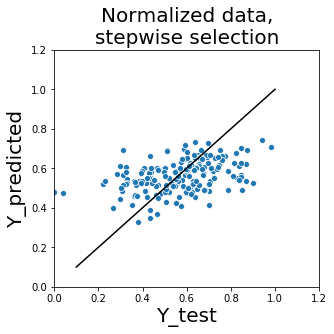

In [275]:
plt.figure(figsize=(5,5))
sns.scatterplot(y2_norm_test.values.reshape(-1,), y_pred_nstep.reshape(-1,))
sns.lineplot((0.1,1), (0.1, 1), color= 'k')
plt.title('Normalized data,\nstepwise selection', fontsize= 20)
plt.xlabel('Y_test', fontsize= 20)
plt.ylabel('Y_predicted', fontsize= 20)
plt.ylim(0, 1.2)
plt.xlim(0, 1.2)


plt.tight_layout(pad= 2)
plt.savefig('Y_test vs y_pred_nstep.png', dpi= 300)
plt.show()

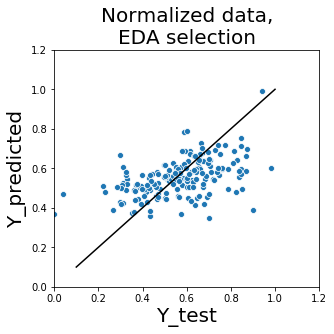

In [276]:
plt.figure(figsize=(5,5))
sns.scatterplot(y2_norm_test.values.reshape(-1,), y_pred_nEDA.reshape(-1,))
sns.lineplot((0.1,1), (0.1, 1), color= 'k')
plt.title('Normalized data,\nEDA selection', fontsize= 20)
plt.xlabel('Y_test', fontsize= 20)
plt.ylabel('Y_predicted', fontsize= 20)
plt.ylim(0, 1.2)
plt.xlim(0, 1.2)


plt.tight_layout(pad= 2)
plt.savefig('Y_test vs y_pred_nEDA.png', dpi= 300)
plt.show()

### One last model to check: Lasso regression

In [278]:
# use this elastic_slide function to use Lasso, Ridge, or a combination of the two regression models

def elastic_slide(X_data, y_data, L1_value= 1, alpha_range= 1, best_model= False):
    import statsmodels.api as sm
    model = sm.OLS(y, X)
    results_1 = model.fit()
    final_results = np.array([]).reshape(-1,4)
    params = []

    for j in alpha_range:
        results_2 = model.fit_regularized(L1_wt=L1_value, alpha=j, start_params=results_1.params)
        final = sm.regression.linear_model.OLSResults(model, results_2.params, model.normalized_cov_params)
        score= [L1_value, j, final.rsquared_adj, final.condition_number]
        final_results = np.vstack([final_results, score])
        params.append([x for x in final.params])

    if best_model:
        return final , final_results , np.array(params) , params[np.argmax(final_results[:,2], out=None)]
    return final , final_results , np.array(params)

In [279]:
# lets try an elastic net with the elastic slide function for non-normalized X2 values
es_model , es_results , es_params , es_best = elastic_slide(X2_train.values, np.log(y2_train.values), L1_value= 1, alpha_range= [0.001, 0.01, 0.1, 0.25, 0.5, 1], best_model= True)
lasso_selected_features = [x for x in [x if abs(x[1]) > 0.01 else None for x in list(zip(X2_train.columns.tolist(),es_best))] if x != None]

lasso_selected_features

[('mme_percap', -0.050844022670047506),
 ('partD30dayrxrate', 0.025344299276455904),
 ('num_SSPs', 0.03222135261587878),
 ('%msm12month', 0.45316560736101785),
 ('MSM_recent_ratio', 0.02290687064137092),
 ('poverty_rate', -0.01106547169842114),
 ('Num_drug_treatment_fac', 0.5467727457196845),
 ('Percent_men', 0.07249629881080663),
 ('income_ratio', 0.12394772172846326)]

In [280]:
# How does the lasso perform? 
# Badly, regardless of giving it Normalized-data or raw-data with or without np.log(y) the performance is similarly poor
es_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      HIV_rel_infection   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     54.85
Date:                Wed, 12 Jun 2019   Prob (F-statistic):          4.11e-239
Time:                        16:38:28   Log-Likelihood:                -5625.6
No. Observations:                2396   AIC:                         1.131e+04
Df Residuals:                    2367   BIC:                         1.148e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Unnamed: 0                    -0.0005      0.001     -0.665      0.506      -0.002       0.001
county_code                 1.754e-05   4.34e-05      0.404      0.686   -6.76e-05       0.000
MH_fac                              0      0.062          0      1.000      -0.121       0.121
Med_MH_fac                          0      0.068          0      1.000      -0.133       0.133
Population                 -1.023e-05   4.18e-06     -2.451      0.014   -1.84e-05   -2.04e-06
drugdeathrate                  0.0264      0.006      4.698      0.000       0.015       0.037
mme_percap                          0      0.000          0      1.000      -0.000       0.000
partD30dayrxrate                    0      0.061          0      1.000      -0.120       0.120
pctunins                            0      0.013          0      1.000      -0.026       0.026
num_SSPs                            0      0.142          0      1.000      -0.278       0.278
bup_phys                            0      0.005          0      1.000      -0.010       0.010
drugdep                             0      0.184          0      1.000      -0.360       0.360
pctunmetneed                   0.0854      0.018      4.690      0.000       0.050       0.121
nonmedpain                          0      0.121          0      1.000      -0.237       0.237
ADULTMEN                    2.952e-05   1.22e-05      2.420      0.016     5.6e-06    5.34e-05
MSM12MTH                       0.0916      0.192      0.476      0.634      -0.286       0.469
MSM5YEAR                      -0.0596      0.124     -0.479      0.632      -0.304       0.184
%msm12month                         0     12.711          0      1.000     -24.925      24.925
%msm5yr                             0      8.221          0      1.000     -16.121      16.121
unemployment_rate                   0      0.021          0      1.000      -0.042       0.042
poverty_rate                        0      0.013          0      1.000      -0.025       0.025
household_income              2.3e-05   6.56e-06      3.504      0.000    1.01e-05    3.59e-05
Mean income                 4.625e-05   3.76e-05      1.231      0.218   -2.74e-05       0.000
Median income              -5.261e-05   4.96e-05     -1.062      0.288      -0.000    4.46e-05
Num_drug_treatment_fac              0      0.011          0      1.000      -0.022       0.022
Num_med_drug_treatment_fac          0      0.016          0      1.000      -0.031       0.031
Percent_men                   -0.0659      0.016     -4.035      0.000      -0.098      -0.034
income_ratio                        0      3.280          0      1.000      -6.432       6.432
MSM_recent_ratio              -0.0664      0.050     -1.339      0.181      -0.164       0.031
===========================================

## Conclusions:
* a stepwise backward elimination approach produced models very similar to manual selection of features from Exploratory Data Analysis
* applying a log-transformation to the target (HIV_rel_infection) drastically improved model performance
* models fit on raw data showed a good adjusted_R_squared statistic, but had poor prediction capability on hold-out data
* normalized models had better fit, reduced colinearity, and gave predictions on unseen hold-out data with an RMSE of approx 5% of hold-out data mean
* the model features have slightly different impact based on the precise model
* the best model was obtained with normalized data using stepwise backward elimination starting with all potential features

In [281]:
model_results_df

,Feature,Impact (%),Model
4,Norm_MSM_recent_ratio,19,Stepwise
6,Norm_income_ratio,19,Stepwise
1,Norm_pctunins,17,Stepwise
2,Norm_pctunmetneed,9,Stepwise
0,Norm_partD30dayrxrate,8,Stepwise
3,Norm_%msm12month,-10,Stepwise
5,Norm_Num_drug_treatment_fac,-15,Stepwise
5,Norm_MSM_recent_ratio,24,EDA
0,Norm_Population,23,EDA
4,Norm_pctunmetneed,8,EDA
